# XGBoost Model

This notebook is exploring the XGBoost model. 

## Importing Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.model_selection import train_test_split

import xgboost as xgb

from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

---
## Reading in Files

In [2]:
# read the file using pandas
train_file = 'split_train_clean.csv'
train = pd.read_csv(train_file)

# read the file using pandas
test_file = 'split_test_clean.csv'
test = pd.read_csv(test_file)

#reviewing columns
train.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Type', 'Name', 'Age', 'Breed1_0',
       'Breed1_1', 'Breed1_2', 'Breed1_3', 'Breed1_4', 'Breed1_5', 'Breed1_6',
       'Breed1_7', 'Breed2_0', 'Breed2_1', 'Breed2_2', 'Breed2_3', 'Breed2_4',
       'Breed2_5', 'Breed2_6', 'MaturitySize', 'FurLength', 'Vaccinated_1',
       'Vaccinated_2', 'Vaccinated_3', 'Dewormed_1', 'Dewormed_2',
       'Dewormed_3', 'Sterilized_1', 'Sterilized_2', 'Sterilized_3', 'Health',
       'Quantity', 'Fee', 'StateID_0', 'StateID_1', 'StateID_2', 'StateID_3',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed',
       'vertex_xs', 'vertex_ys', 'bounding_confidences',
       'bounding_importance_fracs', 'dominant_blues', 'dominant_greens',
       'dominant_reds', 'dominant_pixel_fracs', 'dominant_scores',
       'label_descriptions', 'label_scores', 'doc_scores', 'doc_magnitudes',
       'languages', 'StateName', 'state_population', 'median_state_income',
       'Invalid_name', 'IsTopRescuer', 'RescuerC

---
## Defining Functions

In [3]:
def plot_hist (data, title="", bins=4):
    '''
    Plot the distribution of label predictions.
    '''

    #set up figure and axes
    fig, ax = plt.subplots()
    n, bins, patches = ax.hist(data, bins=bins, range=(0, bins), edgecolor='black', rwidth=0.8)

    #setting labels
    ax.set_title(title)
    ax.set_xlabel('Class')
    ax.set_ylabel('Count')

    #annotating each count total
    for count, rect in zip(n, patches):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height, int(count), ha='center', va='bottom')

    # Get the bin edges and compute the center positions
    bin_edges = np.histogram_bin_edges(data, bins=bins)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Setting x-axis ticks to integers 1 through 4
    x_ticks_labels = range(1, 5)
    plt.xticks(bin_centers, x_ticks_labels)

    plt.show()

In [4]:
# Define function to OHE selected columns
def OHE_vars(train, test, target):
    '''
    Takes in the train and test datasets, and the target feature to encode.
    Fits to the train and then transforms both and returns the entire dataset
    with the target feature transformed.
    '''
    
    # Check if column_name exists in the DataFrame
    if target not in train.columns:
        raise ValueError(f"Column '{target}' does not exist in the DataFrame.")
    
    #creating encoder
    temp_encoder = ce.OneHotEncoder(cols=[target])
    # fitting the encoder to train
    temp_encoder.fit(train)
    # transforming both datasets with encoder
    train = temp_encoder.transform(train)
    test = temp_encoder.transform(test)
    
    return train, test

In [5]:
# Binary Encoding function
def binary_encoding(train, test, target):
    '''
    Takes in the train and test datasets, and the target feature to encode. 
    Fits to the train and then transforms both and returns the entire dataset 
    with the target feature transformed.
    '''
    # Check if column_name exists in the DataFrame
    if target not in train.columns:
        raise ValueError(f"Column '{target}' does not exist in the DataFrame.")
    
    # creating the encoder
    temp_encoder = ce.BinaryEncoder(cols=[target])
    #fitting the encoder to train
    temp_encoder.fit(train)
    #transforming both datasets with encoder
    train = temp_encoder.transform(train)
    test = temp_encoder.transform(test)
    #returning both datasets
    return train, test

---
## Pre-Processing Data
We are performing the following pre-processing of the data:
 - Last minute feature transformations not included in File 3 for 'languages' and 'label_descriptions'
 - Removing irrelevant/problematic features
 - Reclassing the labels to combine the original 0 & 1 classes
 - Downsampling so that each class has the same number of samples. 
 - Shuffling entire dataset and resetting_index

In [6]:
#last minute feature transformations 
#OHE 'languages' feature
train, test = OHE_vars(train, test, 'languages')

#Binary Encoding for 'label_descriptions'
train, test = binary_encoding(train, test, 'label_descriptions')

In [7]:
#dropping features
drop_features = ["Name", "Description", "PetID", "StateName", 'label_scores', 'PhotoAmt', "Unnamed: 0.1", "Unnamed: 0"]
target = 'AdoptionSpeed'
train = train.drop(drop_features, axis=1)
test = test.drop(drop_features, axis=1)

# Group 0 & 1 and relabel target variable in train and test
relabel_dict = { 0:0, 1:0, 2:1, 3:2, 4:3 }
train['AdoptionSpeed'] = train['AdoptionSpeed'].map(relabel_dict)
test['AdoptionSpeed'] = test['AdoptionSpeed'].map(relabel_dict)

# Downsample so all 4 categories have equal reviews in train
group_size = 2607
temp_0 = train[train.AdoptionSpeed.eq(0)].sample(
    n=group_size,
    replace=False,
    random_state=42)

temp_1 = train[train.AdoptionSpeed.eq(1)].sample(
    n=group_size,
    replace=False,
    random_state=42)

temp_2 = train[train.AdoptionSpeed.eq(2)].sample(
    n=group_size,
    replace=False,
    random_state=42)

temp_3 = train[train.AdoptionSpeed.eq(3)].sample(
    n=group_size,
    replace=False,
    random_state=42)

train_bal = pd.concat(
    [temp_0, temp_1, temp_2, temp_3],
    axis=0)

# shuffle df_balanced
train_bal.sample(frac=1, random_state=42) # frac=1 retains all the data
train_bal.reset_index(drop=True, inplace=True) # reset index

print('After downsampling, our data contains', train_bal.shape[0], 'pets and', train_bal.shape[1], 'columns')

#creating a list of features
features = train.columns.tolist()
features.remove('AdoptionSpeed')

After downsampling, our data contains 10428 pets and 94 columns


In [8]:
# Value counts of re-labeled AdoptionSpeed
train_bal['AdoptionSpeed'].value_counts()

0    2607
1    2607
2    2607
3    2607
Name: AdoptionSpeed, dtype: int64

---
## Split into Training and Validation Sets
We are reserving 20% of our dataset for validation.  To ensure class balance we created above we are stratifying the split. 

In [9]:
#Split into X and Y arrays
X = np.array(train_bal.drop('AdoptionSpeed', axis=1))
y = np.array(train_bal['AdoptionSpeed'])

#Split into train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  stratify = y,
                                                  random_state=42)

# Splitting test data into X and Y arrays
X_test = np.array(test.drop('AdoptionSpeed', axis=1))
y_test = np.array(test['AdoptionSpeed'])

# Check distribution
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 2085, 1: 2086, 2: 2085, 3: 2086}

---
## Building Selected Model

Below is the finalized, tuned model that we have selected.  Please see "Exploring Various Hyper-parameters Individually" section below where tuning of the various parameters were explored. 

[0]	validation_0-merror:0.59182	validation_1-merror:0.62128
[20]	validation_0-merror:0.56210	validation_1-merror:0.58293
[40]	validation_0-merror:0.55227	validation_1-merror:0.58198
[60]	validation_0-merror:0.54387	validation_1-merror:0.57814
[80]	validation_0-merror:0.54040	validation_1-merror:0.57670
[100]	validation_0-merror:0.53776	validation_1-merror:0.57910
[120]	validation_0-merror:0.53500	validation_1-merror:0.57622
[140]	validation_0-merror:0.53428	validation_1-merror:0.57478
[160]	validation_0-merror:0.53428	validation_1-merror:0.57766
[180]	validation_0-merror:0.53368	validation_1-merror:0.57718
[194]	validation_0-merror:0.53357	validation_1-merror:0.58006
Train Accuracy: 0.46128026852073845
Validation Accuracy: 0.425215723873442
Weighted F1 Score: 0.4038547756469335


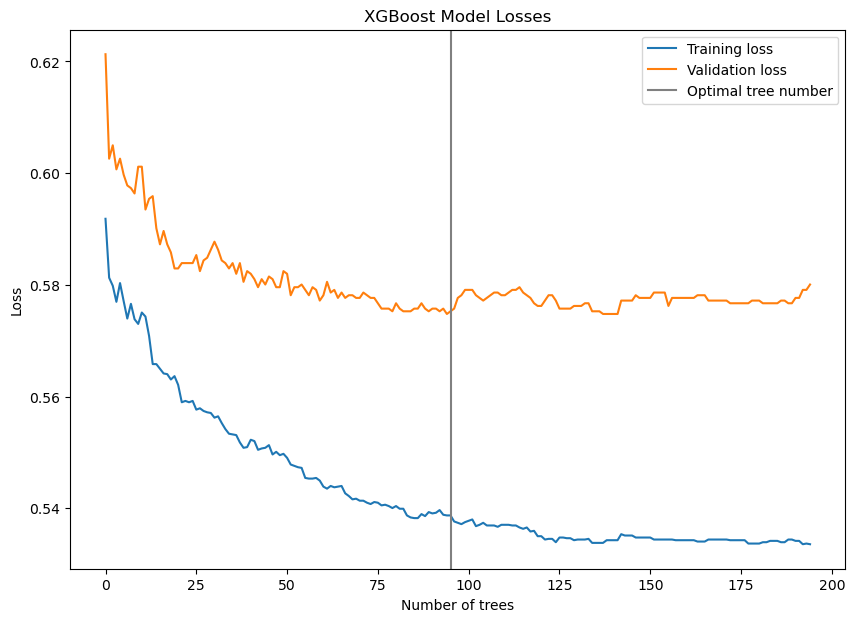

In [10]:
#initialize classifier
xgb_model = xgb.XGBRegressor(
                              objective='multi:softprob', 
                              num_class = 4, 
                              booster='gbtree',
                              eval_metric = 'merror',
                              random_state=42,
                              max_depth = 5,
                              eta = .1,
                              n_estimators=10000,
                              early_stopping_rounds=100,
                              min_child_weight = 10,
                              gamma = 4,
                              colsample_bytree = .7,
                              reg_alpha = 1,
                              reg_lambda = 30,
                            )

#fit
xgb_fitted = xgb_model.fit(X_train, y_train,
                           eval_set=[(X_train, y_train), (X_val, y_val)],
                           verbose=20
                           )

#get training accuracies
y_pred = xgb_fitted.predict(X_train)
y_pred_select = np.argmax(y_pred, axis=1)
acc_train = accuracy_score(y_train, y_pred_select)

#get validation accuracies
y_pred = xgb_fitted.predict(X_val)
y_pred_select = np.argmax(y_pred, axis=1)
acc_valid = accuracy_score(y_val, y_pred_select)

print("Train Accuracy:", acc_train)
print("Validation Accuracy:", acc_valid)

# Checking F1_score
f1 = f1_score(y_val, y_pred_select, average='weighted')
print("Weighted F1 Score:", f1)

#retreiving results
results = xgb_model.evals_result()

#plotting model losses
plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["merror"], label="Training loss")
plt.plot(results["validation_1"]["merror"], label="Validation loss")
plt.axvline(xgb_fitted.best_ntree_limit, color="gray", label="Optimal tree number")
plt.title('XGBoost Model Losses')
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()
plt.show()

---
## Model Evaluation

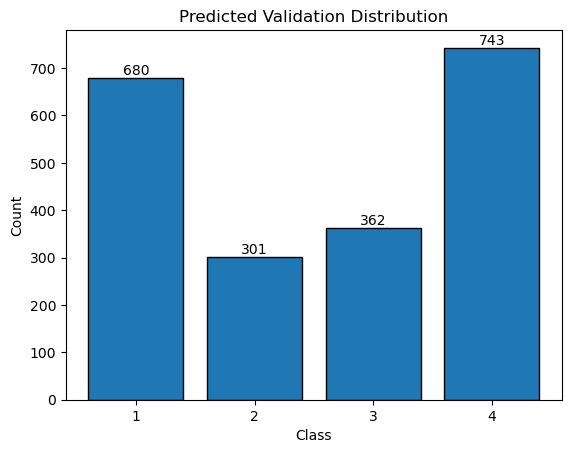

In [11]:
#reviewing the distribution of the predicted labels for Validation set
plot_hist(y_pred_select, "Predicted Validation Distribution")

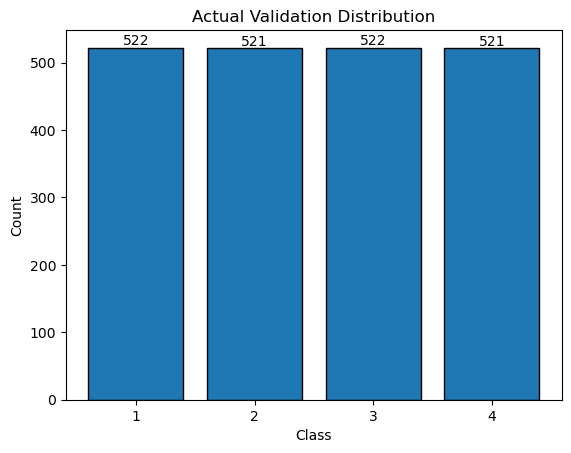

In [12]:
#comparing to distribution of actual validation labels
plot_hist(y_val, "Actual Validation Distribution")

In [13]:
#reviewing the ranking of features by importance

#collecting feature importances from model
fi = xgb_fitted.feature_importances_.argsort()

#dictionary of features and indices
mapping_dict = {i: train.columns[i] for i in range(len(fi))}

#mapping feature names to feature importance indices
np.array([mapping_dict[value] for value in fi])

array(['label_descriptions_0', 'VideoAmt', 'dominant_scores',
       'label_descriptions_1', 'doc_magnitudes', 'languages_1',
       'languages_2', 'languages_3', 'StateID_0', 'languages_4',
       'Fee_bin_1', 'Fee_bin_3', 'Age_bin_3', 'Age_bin_5', 'has_Video',
       'isFemale', 'Brown', 'Fee_binary', 'Dewormed_3', 'isGeneric_Breed',
       'Breed2_3', 'Breed2_0', 'Breed1_0', 'vertex_ys', 'Gray', 'Golden',
       'StateID_3', 'Breed2_6', 'dominant_blues', 'Yellow', 'Cream',
       'label_descriptions_3', 'Black', 'dominant_pixel_fracs',
       'has_Photo', 'Fee', 'Age_bin_2', 'White', 'dominant_greens',
       'Breed2_4', 'label_descriptions_6', 'Breed2_5', 'Fee_bin_2',
       'Age_bin_4', 'Quantity_bin_1', 'bounding_importance_fracs',
       'Quantity_bin_3', 'StateID_2', 'RescuerCount', 'Breed1_2',
       'Vaccinated_3', 'Health', 'bounding_confidences', 'Vaccinated_2',
       'Breed2_1', 'Quantity_binary', 'median_state_income', 'doc_scores',
       'dominant_reds', 'isMale', 'Fur

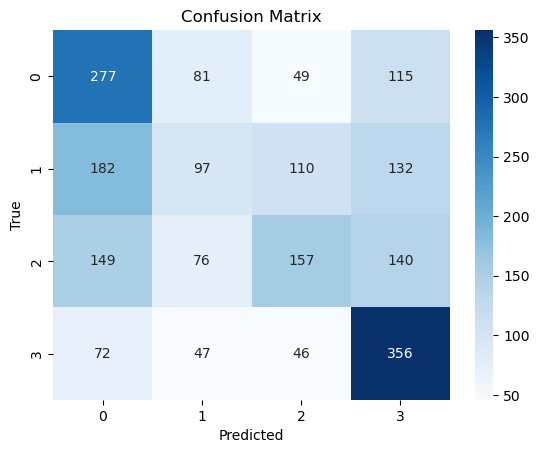

In [14]:
# Create the confusion matrix
cm = confusion_matrix(y_val, y_pred_select)

# Get the class labels from y_val (assuming y_val contains all possible class labels)
class_labels = np.unique(y_val)

# Create a heatmap using Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")

# Display the plot
plt.show()

---
## Model Evaluation with Test Dataset

The below section was created at the very end of this notebook to evaluate performance of our selected model on the test dataset.  We put it ahead of the Hyper-parameter tuning section to keep the chosen model results together. 

In [15]:
# get validation accuracies
y_test_pred = xgb_fitted.predict(X_test)
y_pred_test_select = np.argmax(y_test_pred, axis=1)
acc_test = accuracy_score(y_test, y_pred_test_select)

#returning model accuracies
print("Model", xgb_fitted)
print("Train Accuracy:", acc_train)
print("Validation Accuracy:", acc_valid)
print("Test Accuracy:", acc_test)

# Checking the F1 scores
f1_valid = f1_score(y_val, y_pred_select, average='weighted')
f1_test = f1_score(y_test, y_pred_test_select, average='weighted')
print("Validation Weighted F1 Score:", f1_valid)
print("Test Weighted F1 Score:", f1_test)


Model XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=100,
             enable_categorical=False, eta=0.1, eval_metric='merror',
             feature_types=None, gamma=4, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=10, missing=nan,
             monotone_constraints=None, n_estimators=10000, n_jobs=None,
             num_class=4, num_parallel_tree=None, ...)
Train Accuracy: 0.46128026852073845
Validation Accuracy: 0.425215723873442
Test Accuracy: 0.4168056018672891
Validation Weighted F1 Score: 0.4038547756469335
Test Weighted F1 Score: 0.41161702364069286


---
## Exploring Various Hyperparameters Individually

Below are the various hyper-parameters that we explored in our effort to fine tune our model to our specific dataset. 

#### A) Exploring 'max_depth'

**max_depth** [default 3] – This parameter decides the complexity of the algorithm. The lesser the value assigned, the lower is the ability for the algorithm to pick up most patterns (underfitting). A large value can make the model too complex and pick patterns that do not generalize well (overfitting).

Current value:  2
[0]	validation_0-merror:0.62599	validation_1-merror:0.63471
[99]	validation_0-merror:0.50360	validation_1-merror:0.60307
Weighted F1 Score: 0.38244758308873555
Current value:  3
[0]	validation_0-merror:0.60513	validation_1-merror:0.62128
[99]	validation_0-merror:0.40770	validation_1-merror:0.58341
Weighted F1 Score: 0.4042780818821347
Current value:  4
[0]	validation_0-merror:0.58799	validation_1-merror:0.61553
[99]	validation_0-merror:0.28422	validation_1-merror:0.58725
Weighted F1 Score: 0.4023457207689119
Current value:  5
[0]	validation_0-merror:0.56102	validation_1-merror:0.62320
[99]	validation_0-merror:0.14936	validation_1-merror:0.60115
Weighted F1 Score: 0.39088342777083845
Current value:  6
[0]	validation_0-merror:0.52925	validation_1-merror:0.61745
[99]	validation_0-merror:0.06030	validation_1-merror:0.59444
Weighted F1 Score: 0.399627910777821


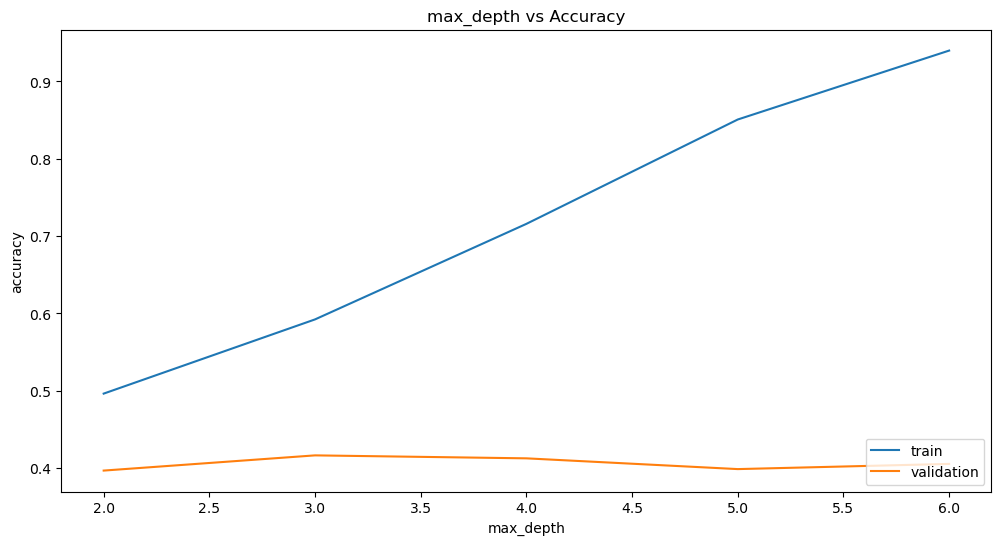

Validation Accuracies:  [0.3969319271332694, 0.41658676893576224, 0.412751677852349, 0.39884947267497606, 0.4055608820709492]


In [16]:
# Initialize lists to track accuracies
train_acc_track = []
valid_acc_track = []
testing = 'max_depth'
samples = range(2, 7, 1)

# exploring range
for sample in samples:
    xgb_model = xgb.XGBRegressor(
                            objective='multi:softprob', 
                              num_class = 4, 
                              booster='gbtree',
                              eval_metric = 'merror',
                              random_state=42,
                              max_depth = sample,
                            )
    #fit
    print("Current value: ", sample)
    xgb_fitted = xgb_model.fit(X_train, y_train,
                           eval_set=[(X_train, y_train), (X_val, y_val)],
                             verbose=100)

    #get training accuracies
    y_pred = xgb_fitted.predict(X_train)
    y_pred_select = np.argmax(y_pred, axis=1)
    acc_train = accuracy_score(y_train, y_pred_select)
    train_acc_track.append(acc_train)

    #get validation accuracies
    y_pred = xgb_fitted.predict(X_val)
    y_pred_select = np.argmax(y_pred, axis=1)
    acc_valid = accuracy_score(y_val, y_pred_select)
    valid_acc_track.append(acc_valid)
    # Checking F1_score
    f1 = f1_score(y_val, y_pred_select, average='weighted')
    print("Weighted F1 Score:", f1)

# Create plot of accuracies
fig, ax = plt.subplots(figsize = (12,6))
ax.set_xlabel(testing)
ax.set_ylabel('accuracy')

# Title and legend
plt.title(f'{testing} vs Accuracy')
ax.plot(samples, train_acc_track)
ax.plot(samples, valid_acc_track)
plt.legend(['train', 'validation'], loc ="lower right")
plt.show()

print('Validation Accuracies: ', valid_acc_track)

#### B) Exploring 'learning_rate'

**learning_rate** [default 0.3] – The rate of learning of the model is inversely proportional to the accuracy of the model. Lowering the learning rate, although slower to train, improves the ability of the model to look for patterns and learn them. If the value is too low then it raises difficulty in the model to converge.

Current value:  0.01
[0]	validation_0-merror:0.56102	validation_1-merror:0.62320
[99]	validation_0-merror:0.52038	validation_1-merror:0.59875
Weighted F1 Score: 0.38596424844472854
Current value:  0.03
[0]	validation_0-merror:0.56102	validation_1-merror:0.62320
[99]	validation_0-merror:0.46811	validation_1-merror:0.58437
Weighted F1 Score: 0.4010787407654688
Current value:  0.05
[0]	validation_0-merror:0.56102	validation_1-merror:0.62320
[99]	validation_0-merror:0.42364	validation_1-merror:0.58245
Weighted F1 Score: 0.40323731498537346
Current value:  0.1
[0]	validation_0-merror:0.56102	validation_1-merror:0.62320
[99]	validation_0-merror:0.34200	validation_1-merror:0.58245
Weighted F1 Score: 0.40380606139408204
Current value:  0.3
[0]	validation_0-merror:0.56102	validation_1-merror:0.62320
[99]	validation_0-merror:0.14936	validation_1-merror:0.60115
Weighted F1 Score: 0.39088342777083845


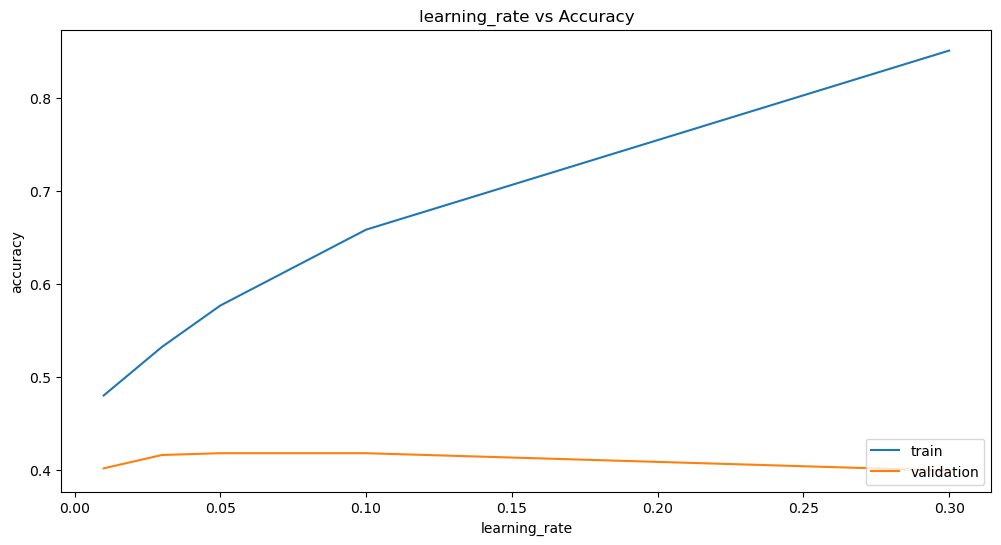

Validation Accuracies:  [0.4012464046021093, 0.4156279961649089, 0.4175455417066155, 0.4175455417066155, 0.39884947267497606]


In [17]:
# Initialize lists to track accuracies
train_acc_track = []
valid_acc_track = []
testing = 'learning_rate'
samples = [.01, .03, .05, .1, .3]

# exploring range
for sample in samples:
    xgb_model = xgb.XGBRegressor(
                            objective='multi:softprob', 
                              num_class = 4, 
                              booster='gbtree',
                              eval_metric = 'merror',
                              random_state=42,
                              max_depth = 5,
                              eta = sample,
                          )


    #fit
    print("Current value: ", sample)
    xgb_fitted = xgb_model.fit(X_train, y_train,
                           eval_set=[(X_train, y_train), (X_val, y_val)],
                             verbose=100)

    #get training accuracies
    y_pred = xgb_fitted.predict(X_train)
    # y_pred_rounded = np.round(y_pred).astype(int)
    y_pred_select = np.argmax(y_pred, axis=1)
    acc_train = accuracy_score(y_train, y_pred_select)
    train_acc_track.append(acc_train)

    #get validation accuracies
    y_pred = xgb_fitted.predict(X_val)
    # y_pred_rounded = np.round(y_pred).astype(int)
    y_pred_select = np.argmax(y_pred, axis=1)
    acc_valid = accuracy_score(y_val, y_pred_select)
    valid_acc_track.append(acc_valid)
    # Checking F1_score
    f1 = f1_score(y_val, y_pred_select, average='weighted')
    print("Weighted F1 Score:", f1)

# Create plot of accuracies
fig, ax = plt.subplots(figsize = (12,6))
ax.set_xlabel(testing)
ax.set_ylabel('accuracy')

# Title and legend
plt.title(f'{testing} vs Accuracy')
ax.plot(samples, train_acc_track)
ax.plot(samples, valid_acc_track)
plt.legend(['train', 'validation'], loc ="lower right")
plt.show()

print('Validation Accuracies: ', valid_acc_track)

#### C) Exploring 'n_estimators' & 'early_stopping_rounds'

The **n_estimators** parameter controls the number of trees in the model. Increasing this value generally improves model performance, but can also lead to overfitting.  The **early_stopping_rounds** is a way to find the optimal number of estimators by monitoring the model's performance on a validation set and stopping the training when the performance starts to degrade.


Current value:  100
[0]	validation_0-merror:0.56102	validation_1-merror:0.62320
[100]	validation_0-merror:0.34117	validation_1-merror:0.58198
[163]	validation_0-merror:0.26444	validation_1-merror:0.58917
Weighted F1 Score: 0.41082829131501725
Current value:  200
[0]	validation_0-merror:0.56102	validation_1-merror:0.62320
[100]	validation_0-merror:0.34117	validation_1-merror:0.58198
[200]	validation_0-merror:0.23040	validation_1-merror:0.58869
[263]	validation_0-merror:0.17873	validation_1-merror:0.58677
Weighted F1 Score: 0.41082829131501725
Current value:  300
[0]	validation_0-merror:0.56102	validation_1-merror:0.62320
[100]	validation_0-merror:0.34117	validation_1-merror:0.58198
[200]	validation_0-merror:0.23040	validation_1-merror:0.58869
[300]	validation_0-merror:0.15212	validation_1-merror:0.58725
[362]	validation_0-merror:0.11868	validation_1-merror:0.59779
Weighted F1 Score: 0.41082829131501725


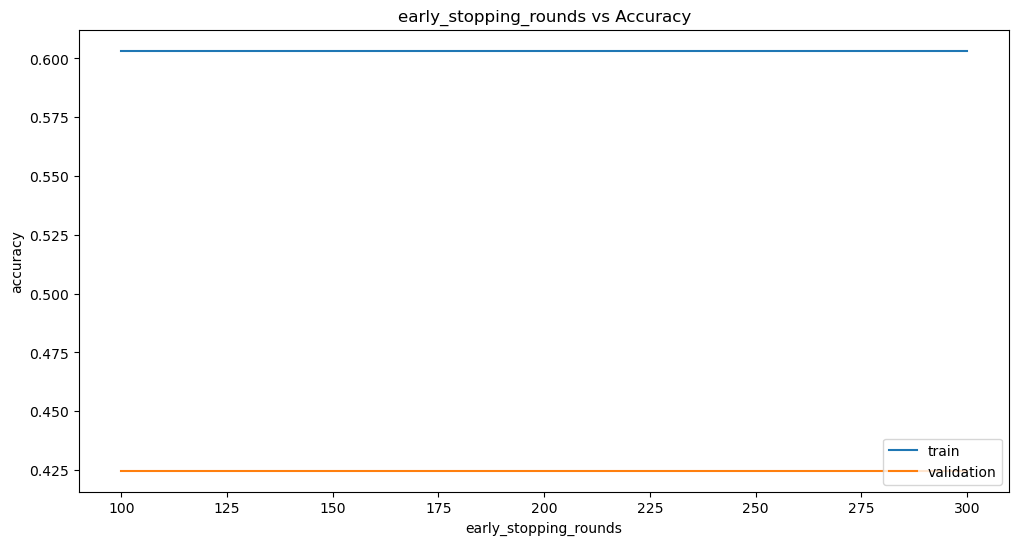

Validation Accuracies:  [0.4247363374880153, 0.4247363374880153, 0.4247363374880153]


In [18]:
# Initialize lists to track accuracies
train_acc_track = []
valid_acc_track = []
testing = 'early_stopping_rounds'
samples = [100, 200, 300]

# exploring range
for sample in samples:
    xgb_model = xgb.XGBRegressor(
                            objective='multi:softprob', 
                              num_class = 4, 
                              booster='gbtree',
                              eval_metric = 'merror',
                              random_state=42,
                              max_depth = 5,
                              eta = .1,
                              n_estimators=10000,
                              early_stopping_rounds=sample,
                          )


    #fit
    print("Current value: ", sample)
    xgb_fitted = xgb_model.fit(X_train, y_train,
                           eval_set=[(X_train, y_train), (X_val, y_val)],
                            verbose=100)

    #get training accuracies
    y_pred = xgb_fitted.predict(X_train)
    # y_pred_rounded = np.round(y_pred).astype(int)
    y_pred_select = np.argmax(y_pred, axis=1)
    acc_train = accuracy_score(y_train, y_pred_select)
    train_acc_track.append(acc_train)

    #get validation accuracies
    y_pred = xgb_fitted.predict(X_val)
    # y_pred_rounded = np.round(y_pred).astype(int)
    y_pred_select = np.argmax(y_pred, axis=1)
    acc_valid = accuracy_score(y_val, y_pred_select)
    valid_acc_track.append(acc_valid)
    # Checking F1_score
    f1 = f1_score(y_val, y_pred_select, average='weighted')
    print("Weighted F1 Score:", f1)

# Create plot of accuracies
fig, ax = plt.subplots(figsize = (12,6))
ax.set_xlabel(testing)
ax.set_ylabel('accuracy')

# Title and legend
plt.title(f'{testing} vs Accuracy')
ax.plot(samples, train_acc_track)
ax.plot(samples, valid_acc_track)
plt.legend(['train', 'validation'], loc ="lower right")
plt.show()

print('Validation Accuracies: ', valid_acc_track)

#### D) Exploring 'min_child_weight'

**min_child_weight** [default 1] –  We know that an extremely deep tree can deliver poor performance due to overfitting. The min_child_weight parameter aims to regularise by limiting the depth of a tree. So, the higher the value of this parameter, the lower are the chances of the model overfitting on the training data.

Current value:  8
[0]	validation_0-merror:0.56114	validation_1-merror:0.61745
[100]	validation_0-merror:0.36610	validation_1-merror:0.58006
[192]	validation_0-merror:0.26576	validation_1-merror:0.57958
Weighted F1 Score: 0.4155103959089384
Current value:  10
[0]	validation_0-merror:0.56317	validation_1-merror:0.61697
[100]	validation_0-merror:0.37245	validation_1-merror:0.57958
[154]	validation_0-merror:0.31024	validation_1-merror:0.58677
Weighted F1 Score: 0.40669866921086884
Current value:  12
[0]	validation_0-merror:0.56317	validation_1-merror:0.61937
[100]	validation_0-merror:0.38048	validation_1-merror:0.58341
[200]	validation_0-merror:0.27955	validation_1-merror:0.58533
[275]	validation_0-merror:0.22656	validation_1-merror:0.59684
Weighted F1 Score: 0.4089158828589949
Current value:  14
[0]	validation_0-merror:0.56401	validation_1-merror:0.61841
[100]	validation_0-merror:0.39307	validation_1-merror:0.58965
[200]	validation_0-merror:0.29549	validation_1-merror:0.59300
[278]	valida

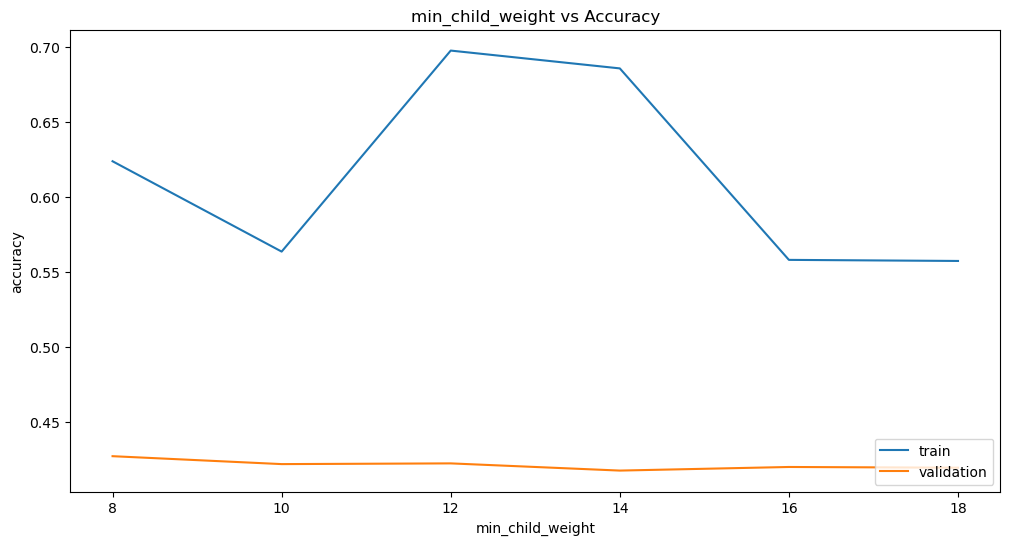

Validation Accuracies:  [0.4271332694151486, 0.4218600191754554, 0.42233940556088206, 0.4175455417066155, 0.4199424736337488, 0.41946308724832215]


In [19]:
# Initialize lists to track accuracies
train_acc_track = []
valid_acc_track = []
testing = 'min_child_weight'
samples = [8, 10, 12, 14, 16, 18]

# exploring range
for sample in samples:
    xgb_model = xgb.XGBRegressor(
                           objective='multi:softprob', 
                              num_class = 4, 
                              booster='gbtree',
                              eval_metric = 'merror',
                              random_state=42,
                              max_depth = 5,
                              eta = .1,
                              n_estimators=10000,
                              early_stopping_rounds=100,
                              min_child_weight = sample,
                          )


    #fit
    print("Current value: ", sample)
    xgb_fitted = xgb_model.fit(X_train, y_train,
                           eval_set=[(X_train, y_train), (X_val, y_val)],
                             verbose=100)

    #get training accuracies
    y_pred = xgb_fitted.predict(X_train)
    # y_pred_rounded = np.round(y_pred).astype(int)
    y_pred_select = np.argmax(y_pred, axis=1)
    acc_train = accuracy_score(y_train, y_pred_select)
    train_acc_track.append(acc_train)

    #get validation accuracies
    y_pred = xgb_fitted.predict(X_val)
    # y_pred_rounded = np.round(y_pred).astype(int)
    y_pred_select = np.argmax(y_pred, axis=1)
    acc_valid = accuracy_score(y_val, y_pred_select)
    valid_acc_track.append(acc_valid)
    # Checking F1_score
    f1 = f1_score(y_val, y_pred_select, average='weighted')
    print("Weighted F1 Score:", f1)

# Create plot of accuracies
fig, ax = plt.subplots(figsize = (12,6))
ax.set_xlabel(testing)
ax.set_ylabel('accuracy')

# Title and legend
plt.title(f'{testing} vs Accuracy')
ax.plot(samples, train_acc_track)
ax.plot(samples, valid_acc_track)
plt.legend(['train', 'validation'], loc ="lower right")
plt.show()

print('Validation Accuracies: ', valid_acc_track)

#### E) Exploring 'gamma'

**gamma** [default 0] – This is a regularization parameter that can range from 0 to infinity. Higher the value, higher is the strength of regularization, lower are the chances of overfitting (but can underfit if it’s too large). Hence, this parameter varies across all types of datasets.

Current value:  0
[0]	validation_0-merror:0.56317	validation_1-merror:0.61697
[100]	validation_0-merror:0.37245	validation_1-merror:0.57958
[154]	validation_0-merror:0.31024	validation_1-merror:0.58677
Weighted F1 Score: 0.40669866921086884
Current value:  1
[0]	validation_0-merror:0.56317	validation_1-merror:0.61697
[100]	validation_0-merror:0.37833	validation_1-merror:0.58437
[162]	validation_0-merror:0.31563	validation_1-merror:0.58150
Weighted F1 Score: 0.40990659228588605
Current value:  2
[0]	validation_0-merror:0.56269	validation_1-merror:0.61841
[100]	validation_0-merror:0.40758	validation_1-merror:0.58533
[200]	validation_0-merror:0.38204	validation_1-merror:0.58533
[214]	validation_0-merror:0.38204	validation_1-merror:0.58533
Weighted F1 Score: 0.4038852634581606
Current value:  3
[0]	validation_0-merror:0.56377	validation_1-merror:0.62176
[100]	validation_0-merror:0.44773	validation_1-merror:0.57718
[200]	validation_0-merror:0.44018	validation_1-merror:0.57670
[223]	validati

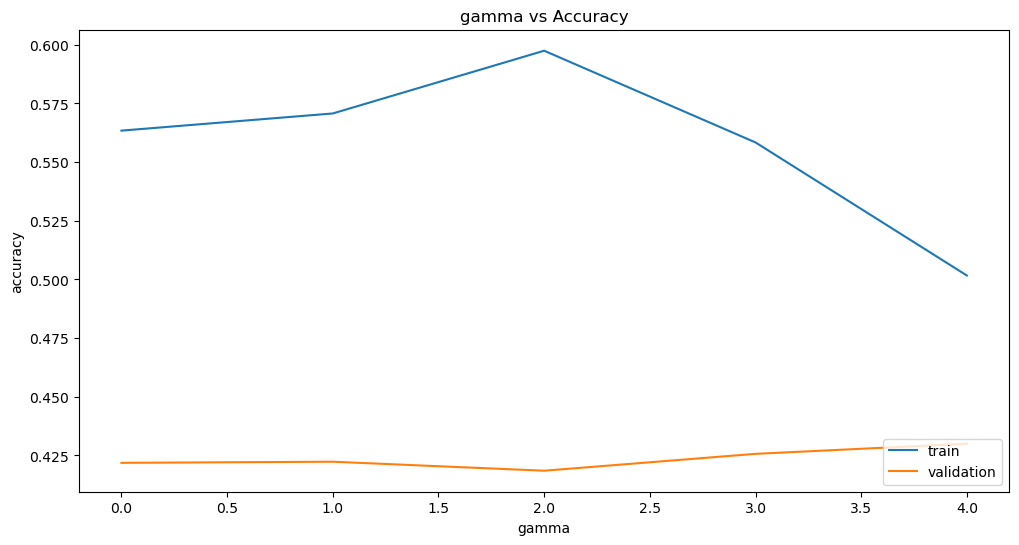

Validation Accuracies:  [0.4218600191754554, 0.42233940556088206, 0.41850431447746883, 0.42569511025886864, 0.43000958772770853]


In [20]:
# Initialize lists to track accuracies
train_acc_track = []
valid_acc_track = []
testing = 'gamma'
samples = range(0, 5, 1)

# exploring range
for sample in samples:
    xgb_model = xgb.XGBRegressor(
                            objective='multi:softprob', 
                              num_class = 4, 
                              booster='gbtree',
                              eval_metric = 'merror',
                              random_state=42,
                              max_depth = 5,
                              eta = .1,
                              n_estimators=10000,
                              early_stopping_rounds=100,
                              min_child_weight = 10,
                              gamma = sample,
                          )


    #fit
    print("Current value: ", sample)
    xgb_fitted = xgb_model.fit(X_train, y_train,
                           eval_set=[(X_train, y_train), (X_val, y_val)],
                             verbose=100)

    #get training accuracies
    y_pred = xgb_fitted.predict(X_train)
    # y_pred_rounded = np.round(y_pred).astype(int)
    y_pred_select = np.argmax(y_pred, axis=1)
    acc_train = accuracy_score(y_train, y_pred_select)
    train_acc_track.append(acc_train)

    #get validation accuracies
    y_pred = xgb_fitted.predict(X_val)
    # y_pred_rounded = np.round(y_pred).astype(int)
    y_pred_select = np.argmax(y_pred, axis=1)
    acc_valid = accuracy_score(y_val, y_pred_select)
    valid_acc_track.append(acc_valid)
    # Checking F1_score
    f1 = f1_score(y_val, y_pred_select, average='weighted')
    print("Weighted F1 Score:", f1)

# Create plot of accuracies
fig, ax = plt.subplots(figsize = (12,6))
ax.set_xlabel(testing)
ax.set_ylabel('accuracy')

# Title and legend
plt.title(f'{testing} vs Accuracy')
ax.plot(samples, train_acc_track)
ax.plot(samples, valid_acc_track)
plt.legend(['train', 'validation'], loc ="lower right")
plt.show()

print('Validation Accuracies: ', valid_acc_track)

#### F) Exploring 'colsample_bytree'

**colsample_bytree** [default 1.0] – This parameter instructs the algorithm on the fraction of the total number of features/ predictors to be used for a tree during training. This means that every tree might use a different set of features for prediction and hence reduce the chances of overfitting and also improve the speed of training as not all the features are being used in every tree. The value ranges from 0 to 1.

Current value:  4
[0]	validation_0-merror:0.60357	validation_1-merror:0.63423
[100]	validation_0-merror:0.49544	validation_1-merror:0.58629
[200]	validation_0-merror:0.47794	validation_1-merror:0.57862
[300]	validation_0-merror:0.46727	validation_1-merror:0.57910
[358]	validation_0-merror:0.46404	validation_1-merror:0.57814
Weighted F1 Score: 0.4075083959864979
Current value:  5
[0]	validation_0-merror:0.59446	validation_1-merror:0.63039
[100]	validation_0-merror:0.49377	validation_1-merror:0.58245
[200]	validation_0-merror:0.46955	validation_1-merror:0.58245
[208]	validation_0-merror:0.46943	validation_1-merror:0.58341
Weighted F1 Score: 0.4053452813750884
Current value:  6
[0]	validation_0-merror:0.59686	validation_1-merror:0.61937
[100]	validation_0-merror:0.48933	validation_1-merror:0.58293
[170]	validation_0-merror:0.47794	validation_1-merror:0.58437
Weighted F1 Score: 0.40634149786039214
Current value:  7
[0]	validation_0-merror:0.59194	validation_1-merror:0.62848
[100]	validatio

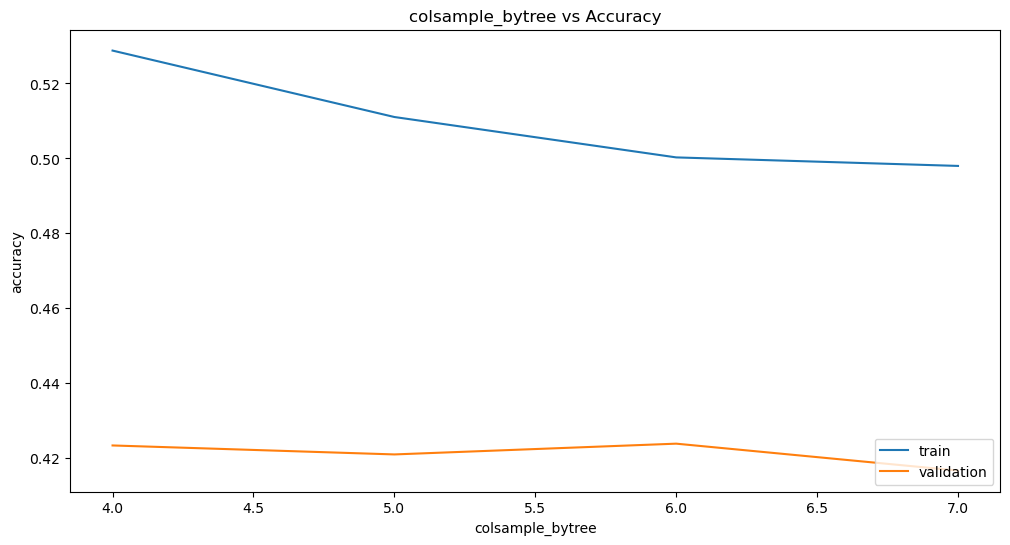

Validation Accuracies:  [0.4232981783317354, 0.42090124640460214, 0.42377756471716205, 0.41658676893576224]


In [21]:
# Initialize lists to track accuracies
train_acc_track = []
valid_acc_track = []
testing = 'colsample_bytree'
samples = range(4,8,1)

# exploring range
for sample in samples:
    xgb_model = xgb.XGBRegressor(
                            objective='multi:softprob', 
                              num_class = 4, 
                              booster='gbtree',
                              eval_metric = 'merror',
                              random_state=42,
                              max_depth = 5,
                              eta = .1,
                              n_estimators=10000,
                              early_stopping_rounds=100,
                              min_child_weight = 10,
                              gamma = 4,
                              colsample_bytree = sample/10,
                          )


    #fit
    print("Current value: ", sample)
    xgb_fitted = xgb_model.fit(X_train, y_train,
                           eval_set=[(X_train, y_train), (X_val, y_val)],
                             verbose=100)

    #get training accuracies
    y_pred = xgb_fitted.predict(X_train)
    # y_pred_rounded = np.round(y_pred).astype(int)
    y_pred_select = np.argmax(y_pred, axis=1)
    acc_train = accuracy_score(y_train, y_pred_select)
    train_acc_track.append(acc_train)

    #get validation accuracies
    y_pred = xgb_fitted.predict(X_val)
    # y_pred_rounded = np.round(y_pred).astype(int)
    y_pred_select = np.argmax(y_pred, axis=1)
    acc_valid = accuracy_score(y_val, y_pred_select)
    valid_acc_track.append(acc_valid)
    # Checking F1_score
    f1 = f1_score(y_val, y_pred_select, average='weighted')
    print("Weighted F1 Score:", f1)

# Create plot of accuracies
fig, ax = plt.subplots(figsize = (12,6))
ax.set_xlabel(testing)
ax.set_ylabel('accuracy')

# Title and legend
plt.title(f'{testing} vs Accuracy')
ax.plot(samples, train_acc_track)
ax.plot(samples, valid_acc_track)
plt.legend(['train', 'validation'], loc ="lower right")
plt.show()

print('Validation Accuracies: ', valid_acc_track)

#### G) Exploring 'subsample'

**subsample** [default 1.0] – Similar to colsample_bytree, the subsample parameter instructs the algorithm on the fraction of the total number of instances to be used for a tree during training. This also reduces the chances of overfitting and improves training time.

Current value:  2
[0]	validation_0-merror:0.62767	validation_1-merror:0.63471
[100]	validation_0-merror:0.52110	validation_1-merror:0.59971
[122]	validation_0-merror:0.51427	validation_1-merror:0.60115
Weighted F1 Score: 0.3913015504263268
Current value:  4
[0]	validation_0-merror:0.60561	validation_1-merror:0.63231
[100]	validation_0-merror:0.48801	validation_1-merror:0.59204
[200]	validation_0-merror:0.45361	validation_1-merror:0.59827
[215]	validation_0-merror:0.45289	validation_1-merror:0.60019
Weighted F1 Score: 0.4008670076402786
Current value:  6
[0]	validation_0-merror:0.59015	validation_1-merror:0.62560
[100]	validation_0-merror:0.48166	validation_1-merror:0.58869
[174]	validation_0-merror:0.44989	validation_1-merror:0.58581
Weighted F1 Score: 0.40229172176911626
Current value:  8
[0]	validation_0-merror:0.57372	validation_1-merror:0.61409
[100]	validation_0-merror:0.47243	validation_1-merror:0.58677
[200]	validation_0-merror:0.43431	validation_1-merror:0.59300
[232]	validatio

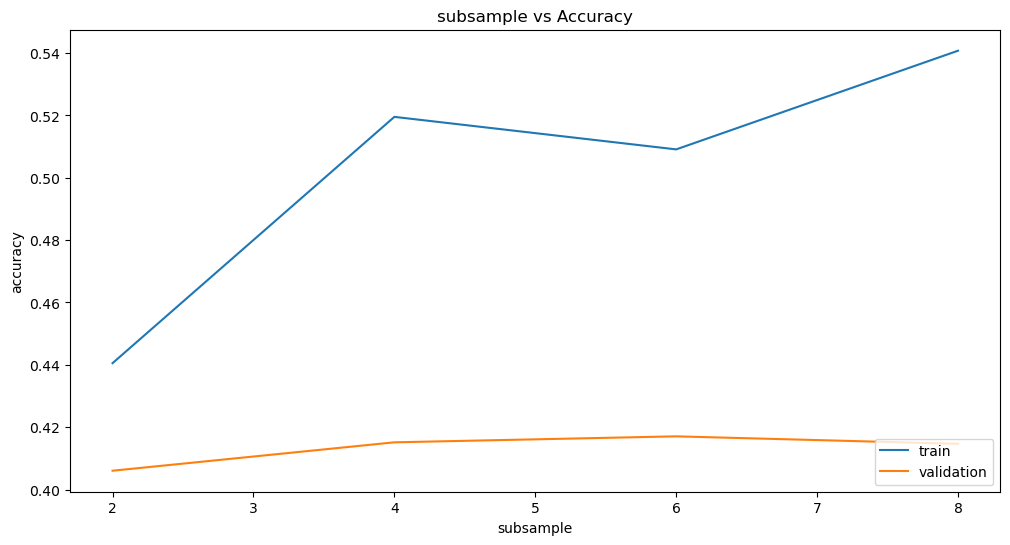

Validation Accuracies:  [0.40604026845637586, 0.41514860977948226, 0.4170661553211889, 0.4146692233940556]


In [22]:
# Initialize lists to track accuracies
train_acc_track = []
valid_acc_track = []
testing = 'subsample'
samples = range(2,10,2)

# exploring range
for sample in samples:
    xgb_model = xgb.XGBRegressor(
                            objective='multi:softprob', 
                              num_class = 4, 
                              booster='gbtree',
                              eval_metric = 'merror',
                              random_state=42,
                              max_depth = 5,
                              eta = .1,
                              n_estimators=10000,
                              early_stopping_rounds=100,
                              min_child_weight = 10,
                              gamma = 4,
                              colsample_bytree = .7,
                              subsample = sample/10,
                          )


    #fit
    print("Current value: ", sample)
    xgb_fitted = xgb_model.fit(X_train, y_train,
                           eval_set=[(X_train, y_train), (X_val, y_val)],
                             verbose=100)
    #get training accuracies
    y_pred = xgb_fitted.predict(X_train)
    # y_pred_rounded = np.round(y_pred).astype(int)
    y_pred_select = np.argmax(y_pred, axis=1)
    acc_train = accuracy_score(y_train, y_pred_select)
    train_acc_track.append(acc_train)

    #get validation accuracies
    y_pred = xgb_fitted.predict(X_val)
    # y_pred_rounded = np.round(y_pred).astype(int)
    y_pred_select = np.argmax(y_pred, axis=1)
    acc_valid = accuracy_score(y_val, y_pred_select)
    valid_acc_track.append(acc_valid)
    # Checking F1_score
    f1 = f1_score(y_val, y_pred_select, average='weighted')
    print("Weighted F1 Score:", f1)

# Create plot of accuracies
fig, ax = plt.subplots(figsize = (12,6))
ax.set_xlabel(testing)
ax.set_ylabel('accuracy')

# Title and legend
plt.title(f'{testing} vs Accuracy')
ax.plot(samples, train_acc_track)
ax.plot(samples, valid_acc_track)
plt.legend(['train', 'validation'], loc ="lower right")
plt.show()

print('Validation Accuracies: ', valid_acc_track)

#### H) Exploring 'reg_alpha'

reg_alpha provides l1 regularization to the weight. Higher values result in more conservative models.

Current value:  0
[0]	validation_0-merror:0.59194	validation_1-merror:0.62848
[100]	validation_0-merror:0.48825	validation_1-merror:0.58917
[146]	validation_0-merror:0.47794	validation_1-merror:0.58725
Weighted F1 Score: 0.399635386621932
Current value:  1
[0]	validation_0-merror:0.59039	validation_1-merror:0.61889
[100]	validation_0-merror:0.50252	validation_1-merror:0.58965
[151]	validation_0-merror:0.49892	validation_1-merror:0.59012
Weighted F1 Score: 0.3986008992679461
Current value:  2
[0]	validation_0-merror:0.59434	validation_1-merror:0.62943
[100]	validation_0-merror:0.51319	validation_1-merror:0.58869
[151]	validation_0-merror:0.50935	validation_1-merror:0.59060
Weighted F1 Score: 0.4016581756553271
Current value:  3
[0]	validation_0-merror:0.60058	validation_1-merror:0.62512
[100]	validation_0-merror:0.52170	validation_1-merror:0.58006
[200]	validation_0-merror:0.51738	validation_1-merror:0.58485
[210]	validation_0-merror:0.51702	validation_1-merror:0.58581
Weighted F1 Score

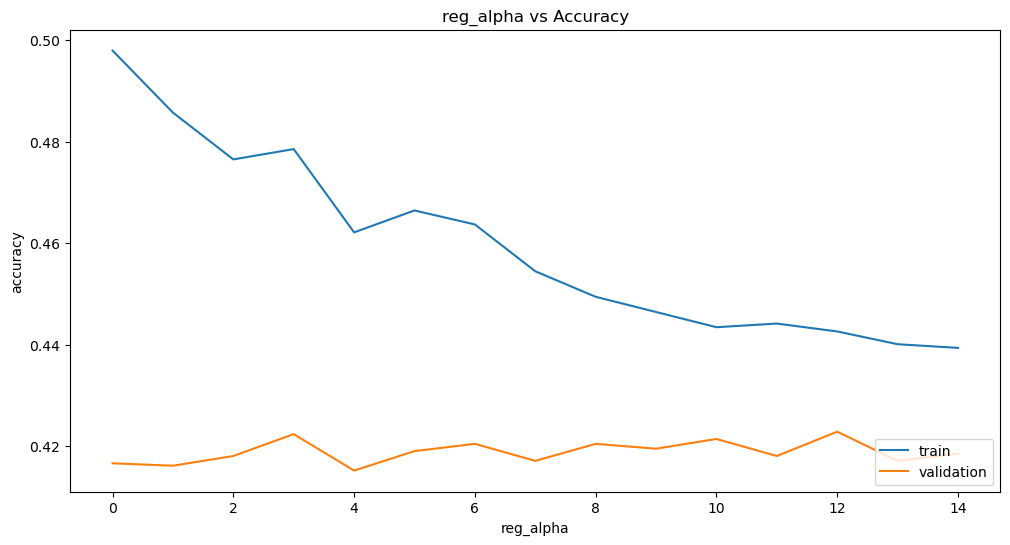

Validation Accuracies:  [0.41658676893576224, 0.4161073825503356, 0.41802492809204217, 0.42233940556088206, 0.41514860977948226, 0.4189837008628955, 0.4204218600191755, 0.4170661553211889, 0.4204218600191755, 0.41946308724832215, 0.42138063279002874, 0.41802492809204217, 0.4228187919463087, 0.4170661553211889, 0.41850431447746883]


In [23]:
# Initialize lists to track accuracies
train_acc_track = []
valid_acc_track = []
testing = 'reg_alpha'
samples = range(0,15,1)

# exploring range
for sample in samples:
    xgb_model = xgb.XGBRegressor(
                            objective='multi:softprob', 
                              num_class = 4, 
                              booster='gbtree',
                              eval_metric = 'merror',
                              random_state=42,
                              max_depth = 5,
                              eta = .1,
                              n_estimators=10000,
                              early_stopping_rounds=100,
                              min_child_weight = 10,
                              gamma = 4,
                              colsample_bytree = .7,
                              reg_alpha = sample,
                          )


    #fit
    print("Current value: ", sample)
    xgb_fitted = xgb_model.fit(X_train, y_train,
                           eval_set=[(X_train, y_train), (X_val, y_val)],
                             verbose=100)
    #get training accuracies
    y_pred = xgb_fitted.predict(X_train)
    # y_pred_rounded = np.round(y_pred).astype(int)
    y_pred_select = np.argmax(y_pred, axis=1)
    acc_train = accuracy_score(y_train, y_pred_select)
    train_acc_track.append(acc_train)

    #get validation accuracies
    y_pred = xgb_fitted.predict(X_val)
    # y_pred_rounded = np.round(y_pred).astype(int)
    y_pred_select = np.argmax(y_pred, axis=1)
    acc_valid = accuracy_score(y_val, y_pred_select)
    valid_acc_track.append(acc_valid)
    # Checking F1_score
    f1 = f1_score(y_val, y_pred_select, average='weighted')
    print("Weighted F1 Score:", f1)

# Create plot of accuracies
fig, ax = plt.subplots(figsize = (12,6))
ax.set_xlabel(testing)
ax.set_ylabel('accuracy')

# Title and legend
plt.title(f'{testing} vs Accuracy')
ax.plot(samples, train_acc_track)
ax.plot(samples, valid_acc_track)
plt.legend(['train', 'validation'], loc ="lower right")
plt.show()

print('Validation Accuracies: ', valid_acc_track)

#### I) Exploring 'reg_lambda'

reg_lambda provides l2 regularization to the weight. Higher values result in more conservative models.

Current value:  0
[0]	validation_0-merror:0.59075	validation_1-merror:0.62081
[100]	validation_0-merror:0.49317	validation_1-merror:0.58773
[136]	validation_0-merror:0.48909	validation_1-merror:0.58629
Weighted F1 Score: 0.40009236507078977
Current value:  10
[0]	validation_0-merror:0.59938	validation_1-merror:0.62368
[100]	validation_0-merror:0.52158	validation_1-merror:0.57958
[162]	validation_0-merror:0.51918	validation_1-merror:0.58102
Weighted F1 Score: 0.40901774625111026
Current value:  20
[0]	validation_0-merror:0.59938	validation_1-merror:0.62464
[100]	validation_0-merror:0.53033	validation_1-merror:0.58341
[190]	validation_0-merror:0.52445	validation_1-merror:0.59060
Weighted F1 Score: 0.39838237489322664
Current value:  30
[0]	validation_0-merror:0.60153	validation_1-merror:0.63375
[100]	validation_0-merror:0.53944	validation_1-merror:0.58581
[165]	validation_0-merror:0.53309	validation_1-merror:0.58629
Weighted F1 Score: 0.40081665342873973
Current value:  40
[0]	validation

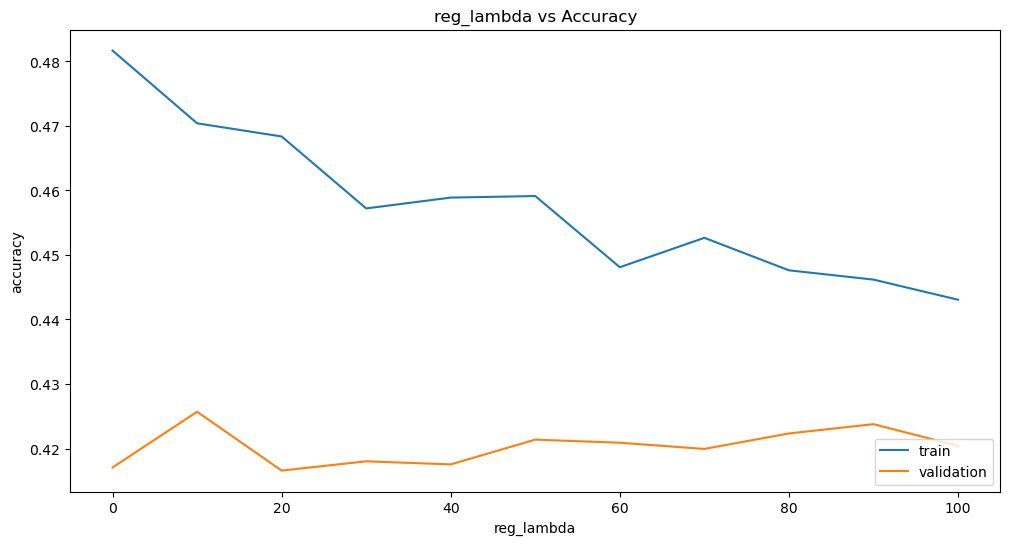

Validation Accuracies:  [0.4170661553211889, 0.42569511025886864, 0.41658676893576224, 0.41802492809204217, 0.4175455417066155, 0.42138063279002874, 0.42090124640460214, 0.4199424736337488, 0.42233940556088206, 0.42377756471716205, 0.4204218600191755]


In [24]:
# Initialize lists to track accuracies
train_acc_track = []
valid_acc_track = []
testing = 'reg_lambda'
samples = range(0,101,10)

# exploring range
for sample in samples:
    xgb_model = xgb.XGBRegressor(
                            objective='multi:softprob', 
                              num_class = 4, 
                              booster='gbtree',
                              eval_metric = 'merror',
                              random_state=42,
                              max_depth = 5,
                              eta = .1,
                              n_estimators=10000,
                              early_stopping_rounds=100,
                              min_child_weight = 10,
                              gamma = 4,
                              colsample_bytree = .7,
                              reg_alpha = 1,
                              reg_lambda = sample,
                          )

    #fit
    print("Current value: ", sample)
    xgb_fitted = xgb_model.fit(X_train, y_train,
                           eval_set=[(X_train, y_train), (X_val, y_val)],
                             verbose=100)
    #get training accuracies
    y_pred = xgb_fitted.predict(X_train)
    # y_pred_rounded = np.round(y_pred).astype(int)
    y_pred_select = np.argmax(y_pred, axis=1)
    acc_train = accuracy_score(y_train, y_pred_select)
    train_acc_track.append(acc_train)

    #get validation accuracies
    y_pred = xgb_fitted.predict(X_val)
    # y_pred_rounded = np.round(y_pred).astype(int)
    y_pred_select = np.argmax(y_pred, axis=1)
    acc_valid = accuracy_score(y_val, y_pred_select)
    valid_acc_track.append(acc_valid)
    # Checking F1_score
    f1 = f1_score(y_val, y_pred_select, average='weighted')
    print("Weighted F1 Score:", f1)

# Create plot of accuracies
fig, ax = plt.subplots(figsize = (12,6))
ax.set_xlabel(testing)
ax.set_ylabel('accuracy')

# Title and legend
plt.title(f'{testing} vs Accuracy')
ax.plot(samples, train_acc_track)
ax.plot(samples, valid_acc_track)
plt.legend(['train', 'validation'], loc ="lower right")
plt.show()

print('Validation Accuracies: ', valid_acc_track)